In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import re
from tqdm import tqdm
from preprocess import evaluate_performance

In [2]:
path = "240818MYK_CADRADS_exam_addv3.2_20240814.xlsx"

data1 = pd.read_excel(path, sheet_name=1)
data2 = pd.read_excel(path, sheet_name=0)

path = "CCTA_addition240929.xlsx"
data3 = pd.read_excel(path)

In [3]:
data2['기관'] = 'S2'

In [4]:
print(len(data1))
print(len(data2))
print(len(data3))

56
53
60


In [5]:
# 컬럼명 변경
data1 = data1.rename(columns={'기관': 'Institution', 'Synthetic report': 'Synthetic_Report'})
data2 = data2.rename(columns={'기관': 'Institution', 'Synthetic Report': 'Synthetic_Report'})
data3 = data3.rename(columns={'Institution': 'Institution', 'Synthetic report': 'Synthetic_Report'})

# concat 수행
data = pd.concat([data1[['Institution', 'Synthetic_Report']], 
                  data2[['Institution', 'Synthetic_Report']], 
                  data3[['Institution', 'Synthetic_Report']]])

In [6]:
set(data['Institution'])

{'B', 'J', 'K', 'S', 'S2'}

In [7]:
for i in list(set(data['Institution'])):
    print(sum(data['Institution']==i))

30
29
53
27
30


In [8]:
# data.loc[data['Institution']=='B', 'Institution']='A' # 인천사랑병원 K.E.Y
# data.loc[data['Institution']=='K', 'Institution']='B' # 고대안암병원 H.S.H
# data.loc[data['Institution']=='J', 'Institution']='C' # 화순전남대병원 J.W.G
# data.loc[data['Institution']=='S', 'Institution']='D' # 서울성모병원 B.K.M
# data.loc[data['Institution']=='S2', 'Institution']='E' # 세브란스병원 L.H.J
data.loc[data['Institution']=='B', 'Institution']='A (n=30)' # 인천사랑병원 K.E.Y
data.loc[data['Institution']=='K', 'Institution']='B (n=29)' # 고대안암병원 H.S.H
data.loc[data['Institution']=='J', 'Institution']='C (n=30)' # 화순전남대병원 J.W.G
data.loc[data['Institution']=='S', 'Institution']='D (n=27)' # 서울성모병원 B.K.M
data.loc[data['Institution']=='S2', 'Institution']='E (n=53)' # 세브란스병원 L.H.J

In [9]:
set(data['Institution'])

{'A (n=30)', 'B (n=29)', 'C (n=30)', 'D (n=27)', 'E (n=53)'}

In [12]:
i=2
print(data.iloc[i])
print(data.iloc[i]['Synthetic_Report'])

Institution                                                  A (n=30)
Synthetic_Report    * Image quality: good quality\n* Dominancy: Ri...
Name: 2, dtype: object
* Image quality: good quality
* Dominancy: Right dominancy
* Coronary Anomaly or variant; Absent.

*Coronary artery stenosis  
1. mid RCA (near AM branching portion): focal noncalcified plaque with moderate to severe stenosis. 
2. LM to proximal LAD ; noncalcified plaque with moderate to severe stenosis 
S/P stent for proximal LAD ; probable severe in-stent restenosis or occlusion. 
3. Hypoplastic LCX. Preserved myocardial thickness 

*Vulnerable plaque : None.
*Other cardiac finding : Preserved myocardial thickness 
*Extracardiac finding : Within normal limits.
Conclusion
1. mid RCA (near AM branching portion): focal noncalcified plaque with moderate to severe stenosis. 
2. LM to proximal LAD ; noncalcified plaque with moderate to severe stenosis 
S/P stent for proximal LAD ; probable severe in-stent restenosis or occlusion.

In [13]:
data.to_csv('external_w_institution.csv')

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def evaluate_performance_by_institution(label, pred):
    institutions = pred['Institution'].unique()
    metrics = {}
    
    modifier_columns = ['I', 'G', 'N', 'HRP', 'E', 'S']
    main_columns = ['CAD-RADS', 'Plaque Burden']
    
    for institution in institutions:
        inst_mask = pred['Institution'] == institution
        metrics[institution] = {}
        
        # Calculate accuracy for main columns (CAD-RADS and Plaque Burden)
        for col in main_columns:
            # Apply specific conditions for each category
            if col == 'CAD-RADS':
                valid_mask = (inst_mask) & (label['N'] == 0)
            elif col == 'Plaque Burden':
                valid_mask = (inst_mask) & (label['S'] == 0) & (label['CAC_available'] == 1)
            
            # Get values only for valid cases
            true_values = label.loc[valid_mask, col]
            pred_values = pred.loc[valid_mask, col]
            
            if len(true_values) > 0:  # Check if there are any valid cases
                acc = accuracy_score(true_values, pred_values)
                metrics[institution][col] = {'Accuracy': acc}
            else:
                metrics[institution][col] = {'Accuracy': np.nan}
        
        # Calculate average accuracy for modifier columns
        modifier_accuracies = []
        for col in modifier_columns:
            true_values = label.loc[inst_mask, col]
            pred_values = pred.loc[inst_mask, col]
            
            acc = accuracy_score(true_values, pred_values)
            modifier_accuracies.append(acc)
        
        # Store the average accuracy for modifiers
        avg_modifier_acc = np.mean(modifier_accuracies)
        metrics[institution]['Modifiers (averaged)'] = {'Accuracy': avg_modifier_acc}
    
    return metrics

In [11]:
label = pd.read_csv('sample_processed_v6.4(외부병원).csv')[['CAD-RADS', 'Plaque Burden', 'I', 'G', 'N', 'HRP', 'E', 'S', 'CAC_available']]

In [12]:
# 전체 케이스 수 대비 각 조건을 만족하는 케이스의 비율을 확인
total_cases = len(label)

# CAD-RADS 조건 확인
cad_rads_valid = (label['N'] == 0).sum()
print(f"CAD-RADS valid cases: {cad_rads_valid}/{total_cases} ({cad_rads_valid/total_cases*100:.1f}%)")

# Plaque Burden 조건 확인
plaque_valid = ((label['S'] == 0) & (label['CAC_available'] == 1)).sum()
print(f"Plaque Burden valid cases: {plaque_valid}/{total_cases} ({plaque_valid/total_cases*100:.1f}%)")

CAD-RADS valid cases: 167/169 (98.8%)
Plaque Burden valid cases: 138/169 (81.7%)


C:\Users\User\AppData\Local\Temp\ipykernel_703196\3967141356.py:81: FutureWarning: The default value of regex will change from True to False in a future version.
  pred_gpt.columns = pred_gpt.columns.str.replace('.1', '')
C:\Users\User\AppData\Local\Temp\ipykernel_703196\3967141356.py:90: FutureWarning: The default value of regex will change from True to False in a future version.
  pred_gemini.columns = pred_gemini.columns.str.replace('.1', '')
C:\Users\User\AppData\Local\Temp\ipykernel_703196\3967141356.py:108: FutureWarning: The default value of regex will change from True to False in a future version.
  pred.columns = pred.columns.str.replace('.1', '')
C:\Users\User\AppData\Local\Temp\ipykernel_703196\3967141356.py:108: FutureWarning: The default value of regex will change from True to False in a future version.
  pred.columns = pred.columns.str.replace('.1', '')
C:\Users\User\AppData\Local\Temp\ipykernel_703196\3967141356.py:108: FutureWarning: The default value of regex will chan

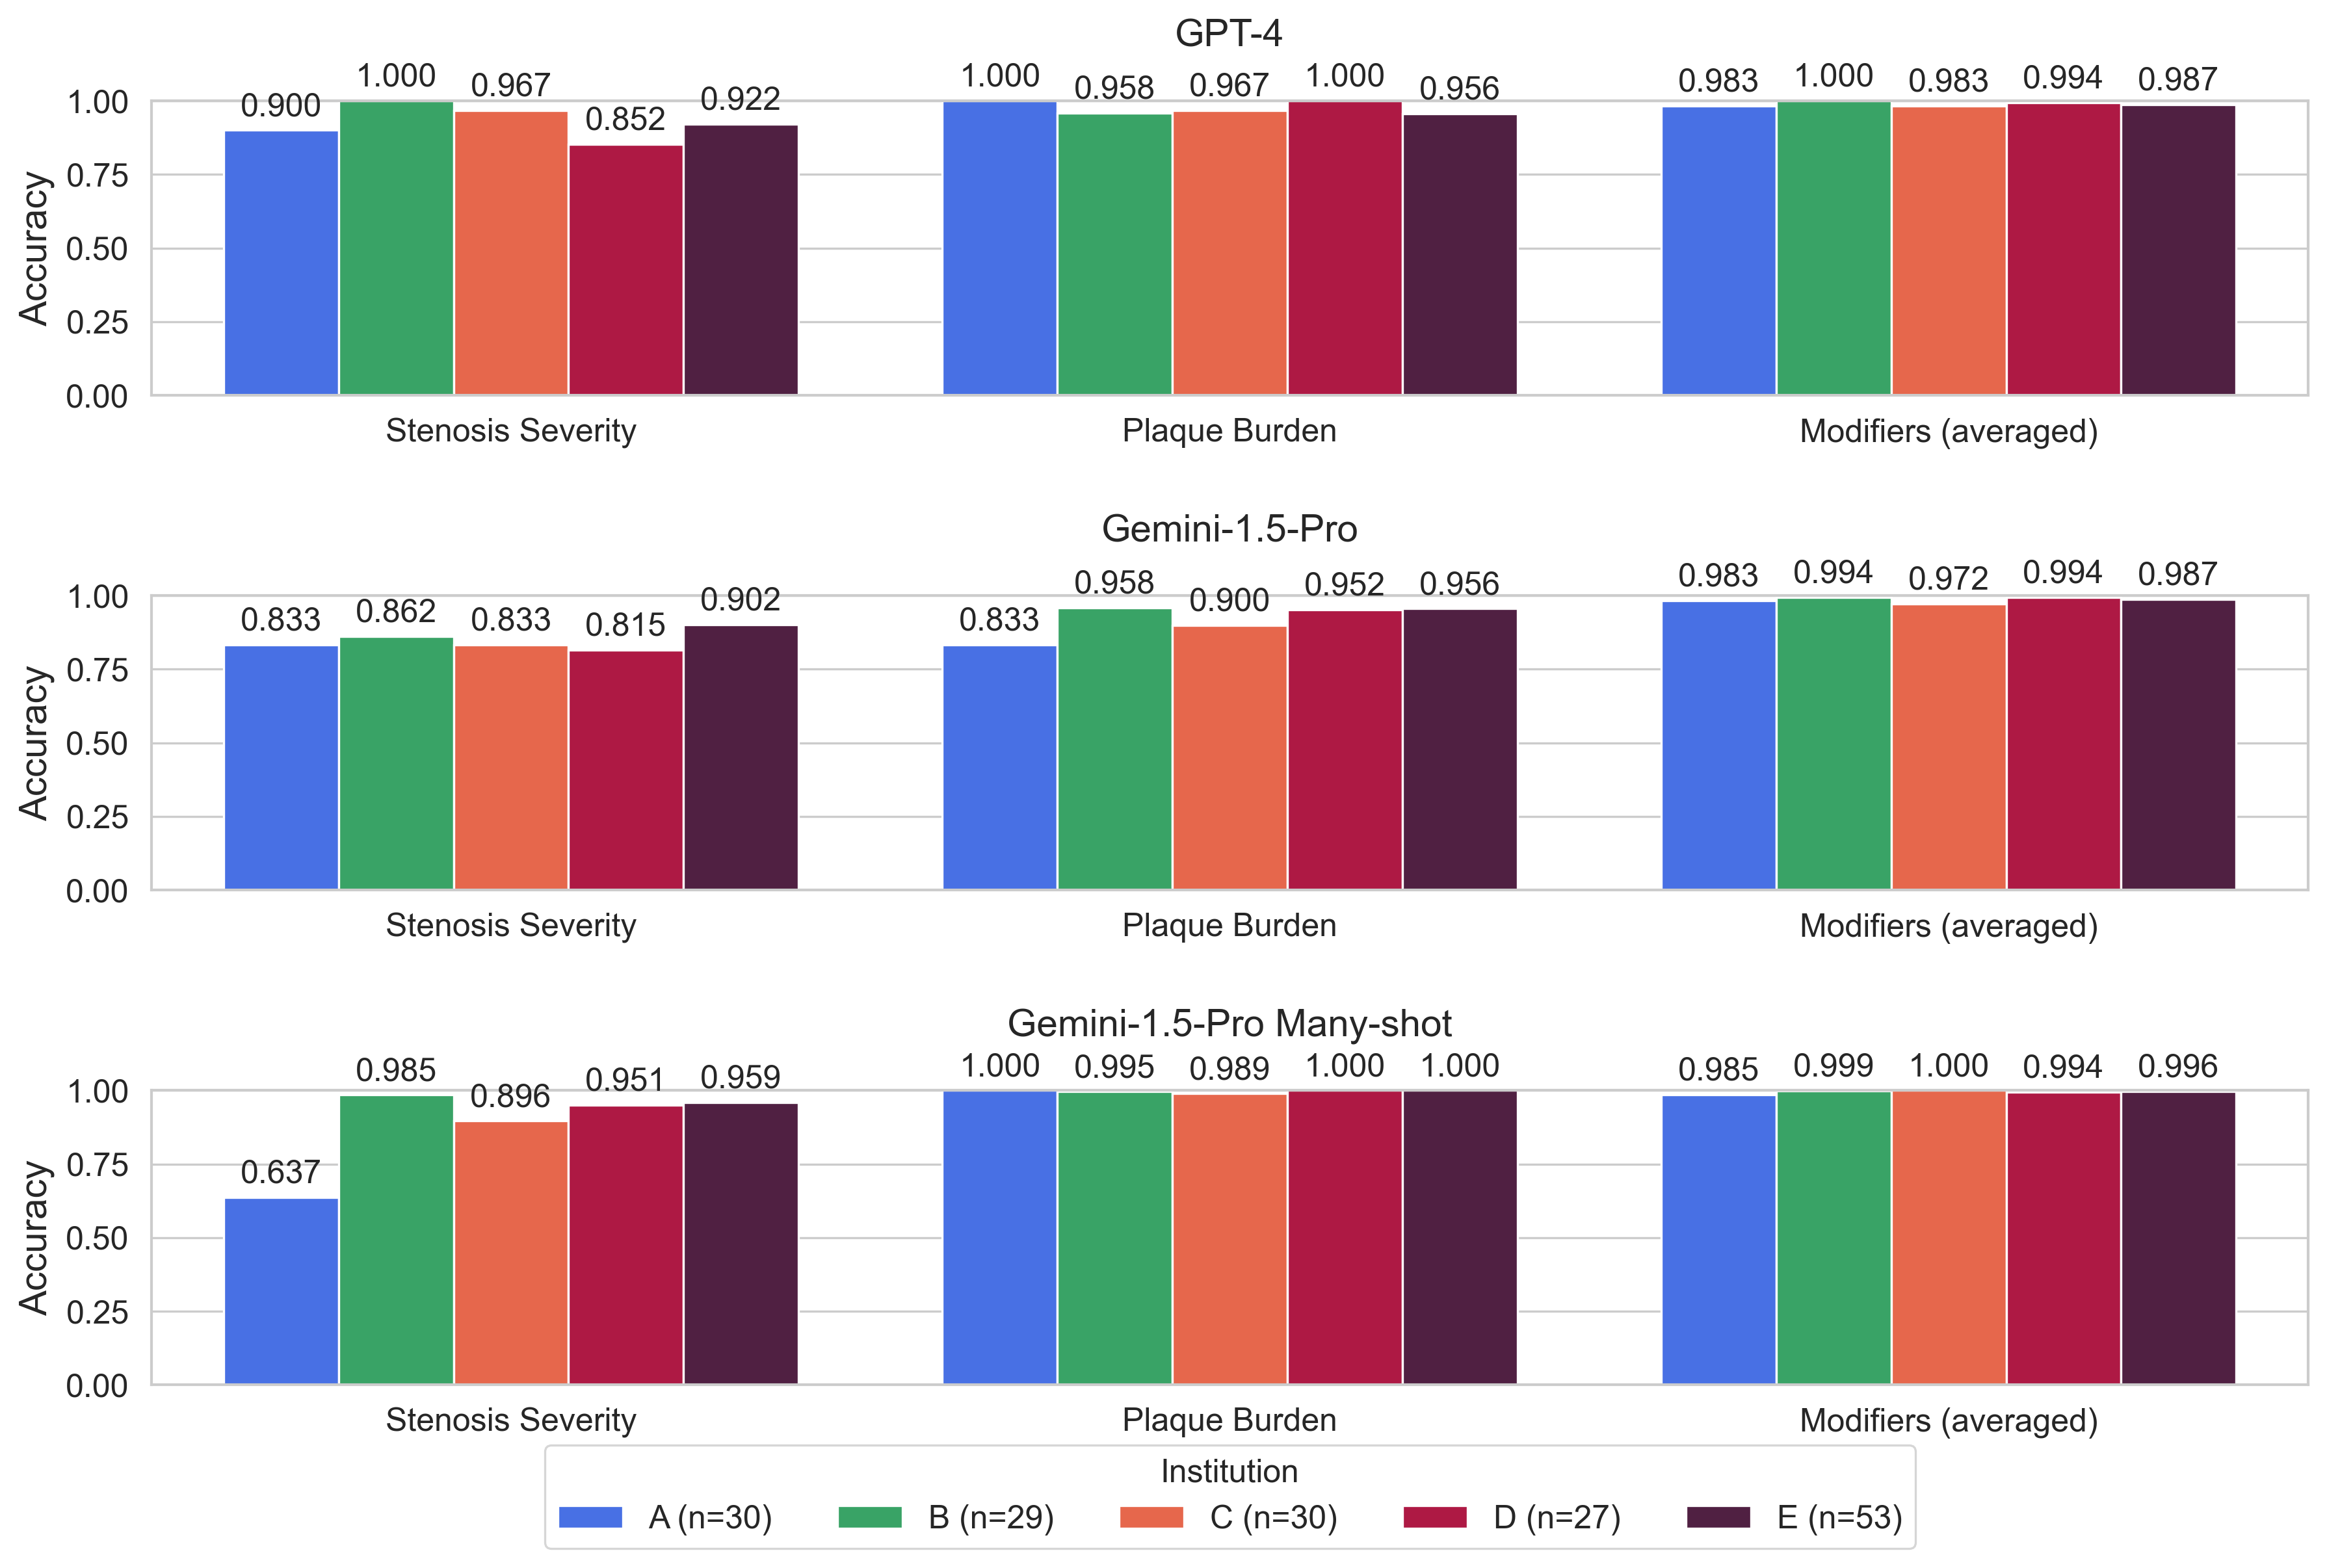

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def plot_combined_accuracy_scores_subplot(metrics_list, models):  # 함수 이름 변경
    """
    여러 모델의 Accuracy 점수를 서브플롯으로 표시
    
    Args:
        metrics_list: List of performance metrics dictionaries [metrics_gpt, metrics_gemini]
        models: List of model names ['GPT-4o', 'Gemini-1.5-Pro']
    """
    # Style settings
    sns.set_style("whitegrid")
    sns.set_context("paper")
    plt.rcParams.update({
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'legend.title_fontsize': 12,
    })

    fig, axes = plt.subplots(3, 1, figsize=(12, 9), dpi=300)
    colors = ['#2E64FE', '#28B463', '#FF5733', '#C70039', '#581845', '#8E44AD']

    category_display = {
        'CAD-RADS': 'Stenosis Severity',
        'Plaque Burden': 'Plaque Burden',
        'Modifiers (averaged)': 'Modifiers (averaged)'
    }

    categories = ['CAD-RADS', 'Plaque Burden', 'Modifiers (averaged)']

    for idx, (metrics, model) in enumerate(zip(metrics_list, models)):
        institutions = list(metrics.keys())
        
        data = []
        for institution in institutions:
            for category in categories:
                acc = metrics[institution][category]['Accuracy']  # F1 Score를 Accuracy로 변경
                data.append({
                    'Institution': institution, 
                    'Category': category_display[category],
                    'Accuracy': acc  # 컬럼명 변경
                })
        
        df = pd.DataFrame(data)

        ax = axes[idx]
        bars = sns.barplot(data=df, x='Category', y='Accuracy',  # y축 레이블 변경
                          hue='Institution', palette=colors, ax=ax)

        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f', padding=3, fontsize=12)

        ax.set_ylabel('Accuracy')  # y축 레이블 변경
        ax.set_ylim([0, 1])
        ax.set_xlabel('')
        ax.set_title(model, pad=20)

        if idx < len(metrics_list) - 1:
            ax.get_legend().remove()
        else:
            ax.legend(loc='upper center', 
                     bbox_to_anchor=(0.5, -0.15),
                     ncol=len(institutions), title='Institution')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=2)
    plt.show()

# 데이터 준비 (GPT-4o)
# pred_path_gpt = "result_1016_external_chatgpt_v6.0_CoT.xlsx"
pred_path_gpt = 'result_1016_external_chatgpt_v6.0_CoT_GPT4.xlsx'
pred_gpt = pd.read_excel(pred_path_gpt)
pred_gpt = pred_gpt.iloc[:,-9:-1]
pred_gpt.columns = pred_gpt.columns.str.replace('.1', '')
pred_gpt = pred_gpt[label.iloc[:,:-1].columns]
pred_gpt['Institution'] = list(data['Institution'])
metrics_gpt = evaluate_performance_by_institution(label, pred_gpt)

# 데이터 준비 (Gemini)
pred_path_gemini = "result_1016_external_gemini_v6.0_CoT.xlsx"
pred_gemini = pd.read_excel(pred_path_gemini)
pred_gemini = pred_gemini.iloc[:,-9:-1]
pred_gemini.columns = pred_gemini.columns.str.replace('.1', '')
pred_gemini = pred_gemini[label.iloc[:,:-1].columns]
pred_gemini['Institution'] = list(data['Institution'])
metrics_gemini = evaluate_performance_by_institution(label, pred_gemini)

RESULTS_DIR = "External_repeated/results"
# 여러 실험 결과파일 불러오기
pattern = f'result_1028_gemini_External_v6.2_CoT_Shot100_Seed*_*.xlsx'
result_files = glob(os.path.join(RESULTS_DIR, pattern))

# 각 실험의 성능 지표를 저장할 리스트
all_performance_metrics = []

# 각 실험 파일에 대해 성능 평가 실행
for result_file in result_files:
    # 예측 결과 읽기
    pred_df = pd.read_excel(result_file)
    pred = pred_df.iloc[:,-9:-1]
    pred.columns = pred.columns.str.replace('.1', '')
    pred = pred[label.iloc[:,:-1].columns]
    pred['Institution'] = list(data['Institution'])
    
    # 성능 평가 실행
    metrics = evaluate_performance_by_institution(label, pred)
    all_performance_metrics.append(metrics)

# 평균 성능 계산
metrics_gemini_manyshot = {}
institutions = list(all_performance_metrics[0].keys())

for institution in institutions:
    metrics_gemini_manyshot[institution] = {}
    categories = list(all_performance_metrics[0][institution].keys())
    
    for category in categories:
        # 해당 기관, 카테고리의 모든 실험 Accuracy 점수 수집
        acc_scores = [metrics[institution][category]['Accuracy']  # F1 Score를 Accuracy로 변경
                    for metrics in all_performance_metrics]
        
        # 평균 계산
        avg_acc = np.mean(acc_scores)
        
        metrics_gemini_manyshot[institution][category] = {'Accuracy': avg_acc}  # 딕셔너리 키 변경

# 그래프 표시 함수 호출
plot_combined_accuracy_scores_subplot(  # 함수 이름 변경
    [metrics_gpt, metrics_gemini, metrics_gemini_manyshot],
    # ['GPT-4o', 'Gemini-1.5-Pro', 'Gemini-1.5-Pro Many-shot']
    ['GPT-4', 'Gemini-1.5-Pro', 'Gemini-1.5-Pro Many-shot']
)

C:\Users\User\AppData\Local\Temp\ipykernel_703196\1591732547.py:80: FutureWarning: The default value of regex will change from True to False in a future version.
  pred_gpt_o.columns = pred_gpt_o.columns.str.replace('.1', '')
C:\Users\User\AppData\Local\Temp\ipykernel_703196\1591732547.py:89: FutureWarning: The default value of regex will change from True to False in a future version.
  pred_gpt.columns = pred_gpt.columns.str.replace('.1', '')
C:\Users\User\AppData\Local\Temp\ipykernel_703196\1591732547.py:98: FutureWarning: The default value of regex will change from True to False in a future version.
  pred_claude.columns = pred_claude.columns.str.replace('.1', '')
C:\Users\User\AppData\Local\Temp\ipykernel_703196\1591732547.py:107: FutureWarning: The default value of regex will change from True to False in a future version.
  pred_gemini.columns = pred_gemini.columns.str.replace('.1', '')
C:\Users\User\AppData\Local\Temp\ipykernel_703196\1591732547.py:55: UserWarning: The palette li

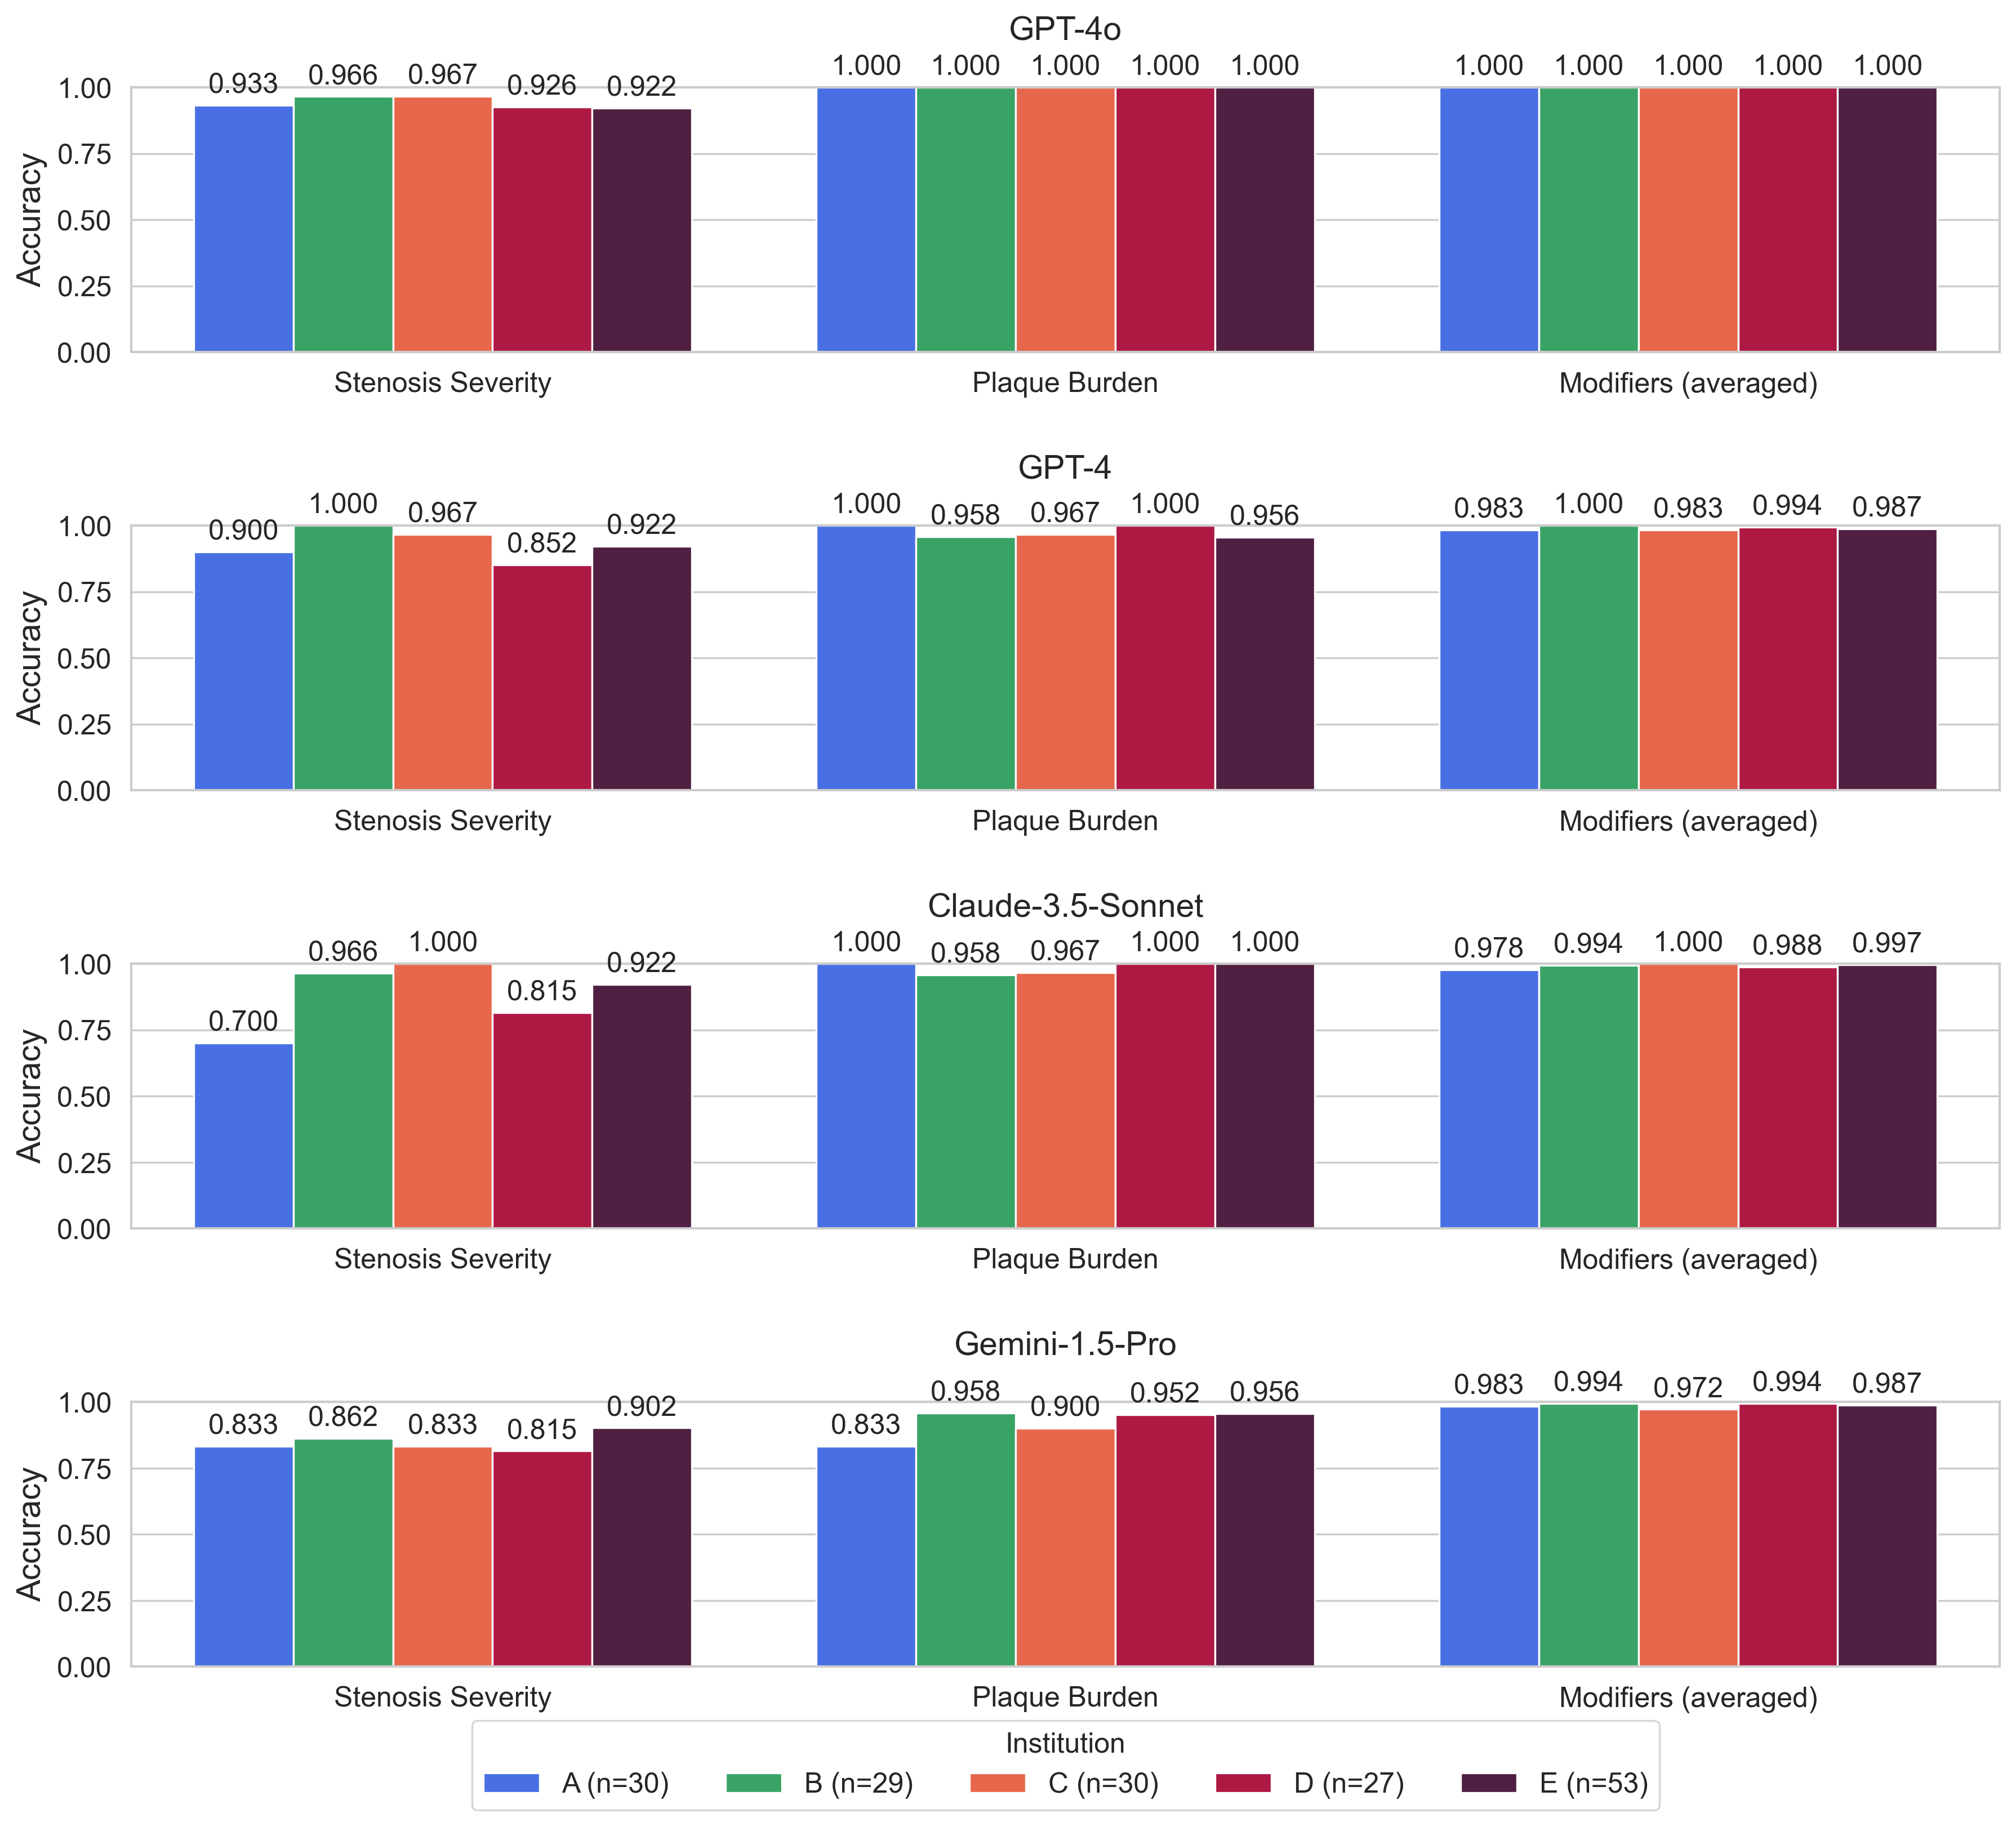

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def plot_combined_accuracy_scores_subplot(metrics_list, models):
    """
    여러 모델의 Accuracy 점수를 서브플롯으로 표시
    
    Args:
        metrics_list: List of performance metrics dictionaries
        models: List of model names
    """
    # Style settings
    sns.set_style("whitegrid")
    sns.set_context("paper")
    plt.rcParams.update({
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'legend.title_fontsize': 12,
    })

    fig, axes = plt.subplots(4, 1, figsize=(12, 12), dpi=300)  # 4개의 서브플롯으로 변경
    colors = ['#2E64FE', '#28B463', '#FF5733', '#C70039', '#581845', '#8E44AD']

    category_display = {
        'CAD-RADS': 'Stenosis Severity',
        'Plaque Burden': 'Plaque Burden',
        'Modifiers (averaged)': 'Modifiers (averaged)'
    }

    categories = ['CAD-RADS', 'Plaque Burden', 'Modifiers (averaged)']

    for idx, (metrics, model) in enumerate(zip(metrics_list, models)):
        institutions = list(metrics.keys())
        
        data = []
        for institution in institutions:
            for category in categories:
                acc = metrics[institution][category]['Accuracy']
                data.append({
                    'Institution': institution, 
                    'Category': category_display[category],
                    'Accuracy': acc
                })
        
        df = pd.DataFrame(data)

        ax = axes[idx]
        bars = sns.barplot(data=df, x='Category', y='Accuracy',
                          hue='Institution', palette=colors, ax=ax)

        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f', padding=3, fontsize=12)

        ax.set_ylabel('Accuracy')
        ax.set_ylim([0, 1])
        ax.set_xlabel('')
        ax.set_title(model, pad=20)

        if idx < len(metrics_list) - 1:
            ax.get_legend().remove()
        else:
            ax.legend(loc='upper center', 
                     bbox_to_anchor=(0.5, -0.15),
                     ncol=len(institutions), title='Institution')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=2)
    plt.show()

# 데이터 준비 (GPT-4o)
pred_path_gpt_o = "result_1016_external_chatgpt_v6.0_CoT.xlsx"
pred_gpt_o = pd.read_excel(pred_path_gpt_o)
pred_gpt_o = pred_gpt_o.iloc[:,-9:-1]
pred_gpt_o.columns = pred_gpt_o.columns.str.replace('.1', '')
pred_gpt_o = pred_gpt_o[label.iloc[:,:-1].columns]
pred_gpt_o['Institution'] = list(data['Institution'])
metrics_gpt_o = evaluate_performance_by_institution(label, pred_gpt_o)

# 데이터 준비 (GPT-4)
pred_path_gpt = 'result_1016_external_chatgpt_v6.0_CoT_GPT4.xlsx'
pred_gpt = pd.read_excel(pred_path_gpt)
pred_gpt = pred_gpt.iloc[:,-9:-1]
pred_gpt.columns = pred_gpt.columns.str.replace('.1', '')
pred_gpt = pred_gpt[label.iloc[:,:-1].columns]
pred_gpt['Institution'] = list(data['Institution'])
metrics_gpt = evaluate_performance_by_institution(label, pred_gpt)

# 데이터 준비 (Claude)
pred_path_claude = "result_1016_external_claude_v6.0_CoT.xlsx"
pred_claude = pd.read_excel(pred_path_claude)
pred_claude = pred_claude.iloc[:,-9:-1]
pred_claude.columns = pred_claude.columns.str.replace('.1', '')
pred_claude = pred_claude[label.iloc[:,:-1].columns]
pred_claude['Institution'] = list(data['Institution'])
metrics_claude = evaluate_performance_by_institution(label, pred_claude)

# 데이터 준비 (Gemini)
pred_path_gemini = "result_1016_external_gemini_v6.0_CoT.xlsx"
pred_gemini = pd.read_excel(pred_path_gemini)
pred_gemini = pred_gemini.iloc[:,-9:-1]
pred_gemini.columns = pred_gemini.columns.str.replace('.1', '')
pred_gemini = pred_gemini[label.iloc[:,:-1].columns]
pred_gemini['Institution'] = list(data['Institution'])
metrics_gemini = evaluate_performance_by_institution(label, pred_gemini)

# 그래프 표시 함수 호출
plot_combined_accuracy_scores_subplot(
    [metrics_gpt_o, metrics_gpt, metrics_claude, metrics_gemini],
    ['GPT-4o', 'GPT-4', 'Claude-3.5-Sonnet', 'Gemini-1.5-Pro'])

C:\Users\User\AppData\Local\Temp\ipykernel_43652\1350098276.py:80: FutureWarning: The default value of regex will change from True to False in a future version.
  pred_gpt_o.columns = pred_gpt_o.columns.str.replace('.1', '')
C:\Users\User\AppData\Local\Temp\ipykernel_43652\1350098276.py:89: FutureWarning: The default value of regex will change from True to False in a future version.
  pred_gpt.columns = pred_gpt.columns.str.replace('.1', '')
C:\Users\User\AppData\Local\Temp\ipykernel_43652\1350098276.py:98: FutureWarning: The default value of regex will change from True to False in a future version.
  pred_claude.columns = pred_claude.columns.str.replace('.1', '')
C:\Users\User\AppData\Local\Temp\ipykernel_43652\1350098276.py:107: FutureWarning: The default value of regex will change from True to False in a future version.
  pred_gemini.columns = pred_gemini.columns.str.replace('.1', '')
C:\Users\User\AppData\Local\Temp\ipykernel_43652\1350098276.py:116: FutureWarning: The default valu

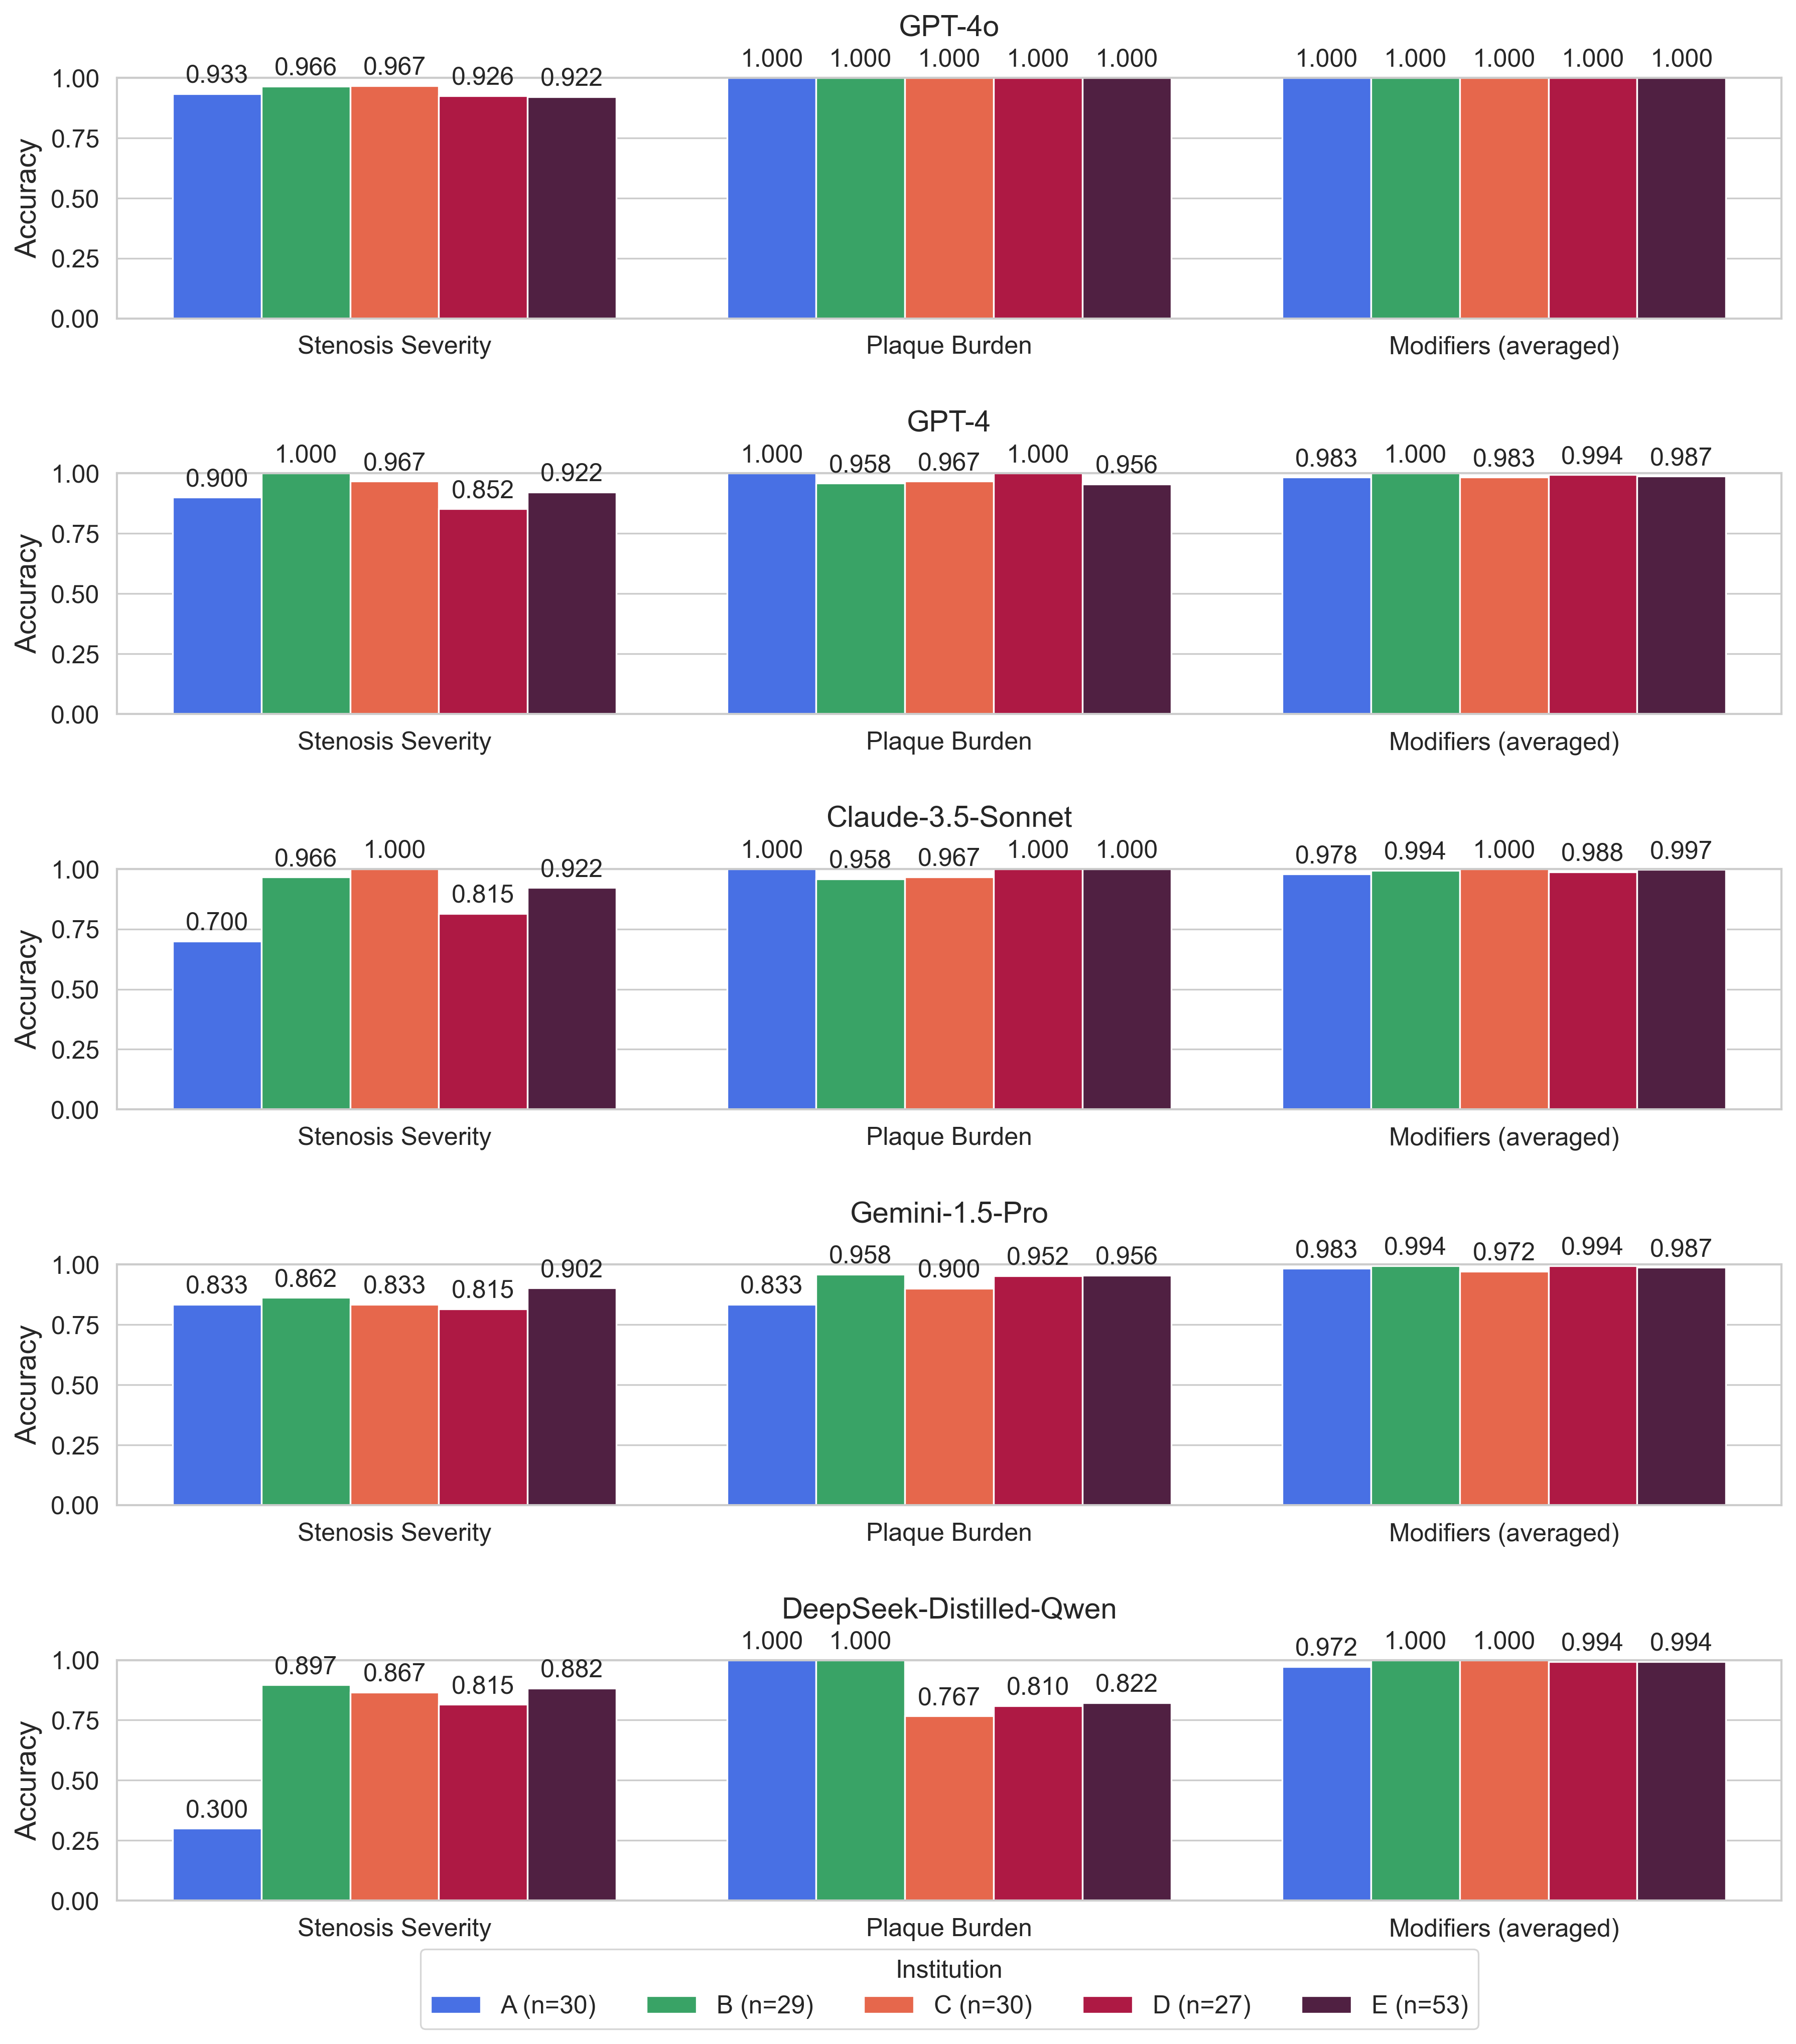

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def plot_combined_accuracy_scores_subplot(metrics_list, models):
    """
    여러 모델의 Accuracy 점수를 서브플롯으로 표시
    
    Args:
        metrics_list: List of performance metrics dictionaries
        models: List of model names
    """
    # Style settings
    sns.set_style("whitegrid")
    sns.set_context("paper")
    plt.rcParams.update({
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'legend.title_fontsize': 12,
    })

    fig, axes = plt.subplots(5, 1, figsize=(12, 15), dpi=300)  # 5개의 서브플롯으로 변경
    colors = ['#2E64FE', '#28B463', '#FF5733', '#C70039', '#581845', '#8E44AD']

    category_display = {
        'CAD-RADS': 'Stenosis Severity',
        'Plaque Burden': 'Plaque Burden',
        'Modifiers (averaged)': 'Modifiers (averaged)'
    }

    categories = ['CAD-RADS', 'Plaque Burden', 'Modifiers (averaged)']

    for idx, (metrics, model) in enumerate(zip(metrics_list, models)):
        institutions = list(metrics.keys())
        
        data = []
        for institution in institutions:
            for category in categories:
                acc = metrics[institution][category]['Accuracy']
                data.append({
                    'Institution': institution, 
                    'Category': category_display[category],
                    'Accuracy': acc
                })
        
        df = pd.DataFrame(data)

        ax = axes[idx]
        bars = sns.barplot(data=df, x='Category', y='Accuracy',
                          hue='Institution', palette=colors, ax=ax)

        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f', padding=3, fontsize=12)

        ax.set_ylabel('Accuracy')
        ax.set_ylim([0, 1])
        ax.set_xlabel('')
        ax.set_title(model, pad=20)

        if idx < len(metrics_list) - 1:
            ax.get_legend().remove()
        else:
            ax.legend(loc='upper center', 
                     bbox_to_anchor=(0.5, -0.15),
                     ncol=len(institutions), title='Institution')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=2)
    plt.show()

# 데이터 준비 (GPT-4o)
pred_path_gpt_o = "result_1016_external_chatgpt_v6.0_CoT.xlsx"
pred_gpt_o = pd.read_excel(pred_path_gpt_o)
pred_gpt_o = pred_gpt_o.iloc[:,-9:-1]
pred_gpt_o.columns = pred_gpt_o.columns.str.replace('.1', '')
pred_gpt_o = pred_gpt_o[label.iloc[:,:-1].columns]
pred_gpt_o['Institution'] = list(data['Institution'])
metrics_gpt_o = evaluate_performance_by_institution(label, pred_gpt_o)

# 데이터 준비 (GPT-4)
pred_path_gpt = 'result_1016_external_chatgpt_v6.0_CoT_GPT4.xlsx'
pred_gpt = pd.read_excel(pred_path_gpt)
pred_gpt = pred_gpt.iloc[:,-9:-1]
pred_gpt.columns = pred_gpt.columns.str.replace('.1', '')
pred_gpt = pred_gpt[label.iloc[:,:-1].columns]
pred_gpt['Institution'] = list(data['Institution'])
metrics_gpt = evaluate_performance_by_institution(label, pred_gpt)

# 데이터 준비 (Claude)
pred_path_claude = "result_1016_external_claude_v6.0_CoT.xlsx"
pred_claude = pd.read_excel(pred_path_claude)
pred_claude = pred_claude.iloc[:,-9:-1]
pred_claude.columns = pred_claude.columns.str.replace('.1', '')
pred_claude = pred_claude[label.iloc[:,:-1].columns]
pred_claude['Institution'] = list(data['Institution'])
metrics_claude = evaluate_performance_by_institution(label, pred_claude)

# 데이터 준비 (Gemini)
pred_path_gemini = "result_1016_external_gemini_v6.0_CoT.xlsx"
pred_gemini = pd.read_excel(pred_path_gemini)
pred_gemini = pred_gemini.iloc[:,-9:-1]
pred_gemini.columns = pred_gemini.columns.str.replace('.1', '')
pred_gemini = pred_gemini[label.iloc[:,:-1].columns]
pred_gemini['Institution'] = list(data['Institution'])
metrics_gemini = evaluate_performance_by_institution(label, pred_gemini)

# 데이터 준비 (DeepSeek)
pred_path_deepseek = "result_0213_external_deepseek_v6.4_CoT.xlsx"
pred_deepseek = pd.read_excel(pred_path_deepseek)
pred_deepseek = pred_deepseek.iloc[:,-9:-1]
pred_deepseek.columns = pred_deepseek.columns.str.replace('.1', '')
pred_deepseek = pred_deepseek[label.iloc[:,:-1].columns]
pred_deepseek['Institution'] = list(data['Institution'])
metrics_deepseek = evaluate_performance_by_institution(label, pred_deepseek)

# 그래프 표시 함수 호출
plot_combined_accuracy_scores_subplot(
    [metrics_gpt_o, metrics_gpt, metrics_claude, metrics_gemini, metrics_deepseek],
    ['GPT-4o', 'GPT-4', 'Claude-3.5-Sonnet', 'Gemini-1.5-Pro', 'DeepSeek-Distilled-Qwen'])

C:\Users\User\AppData\Local\Temp\ipykernel_216452\2277892280.py:55: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  bars = sns.barplot(data=df, x='Category', y='Accuracy',
C:\Users\User\AppData\Local\Temp\ipykernel_216452\2277892280.py:55: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  bars = sns.barplot(data=df, x='Category', y='Accuracy',


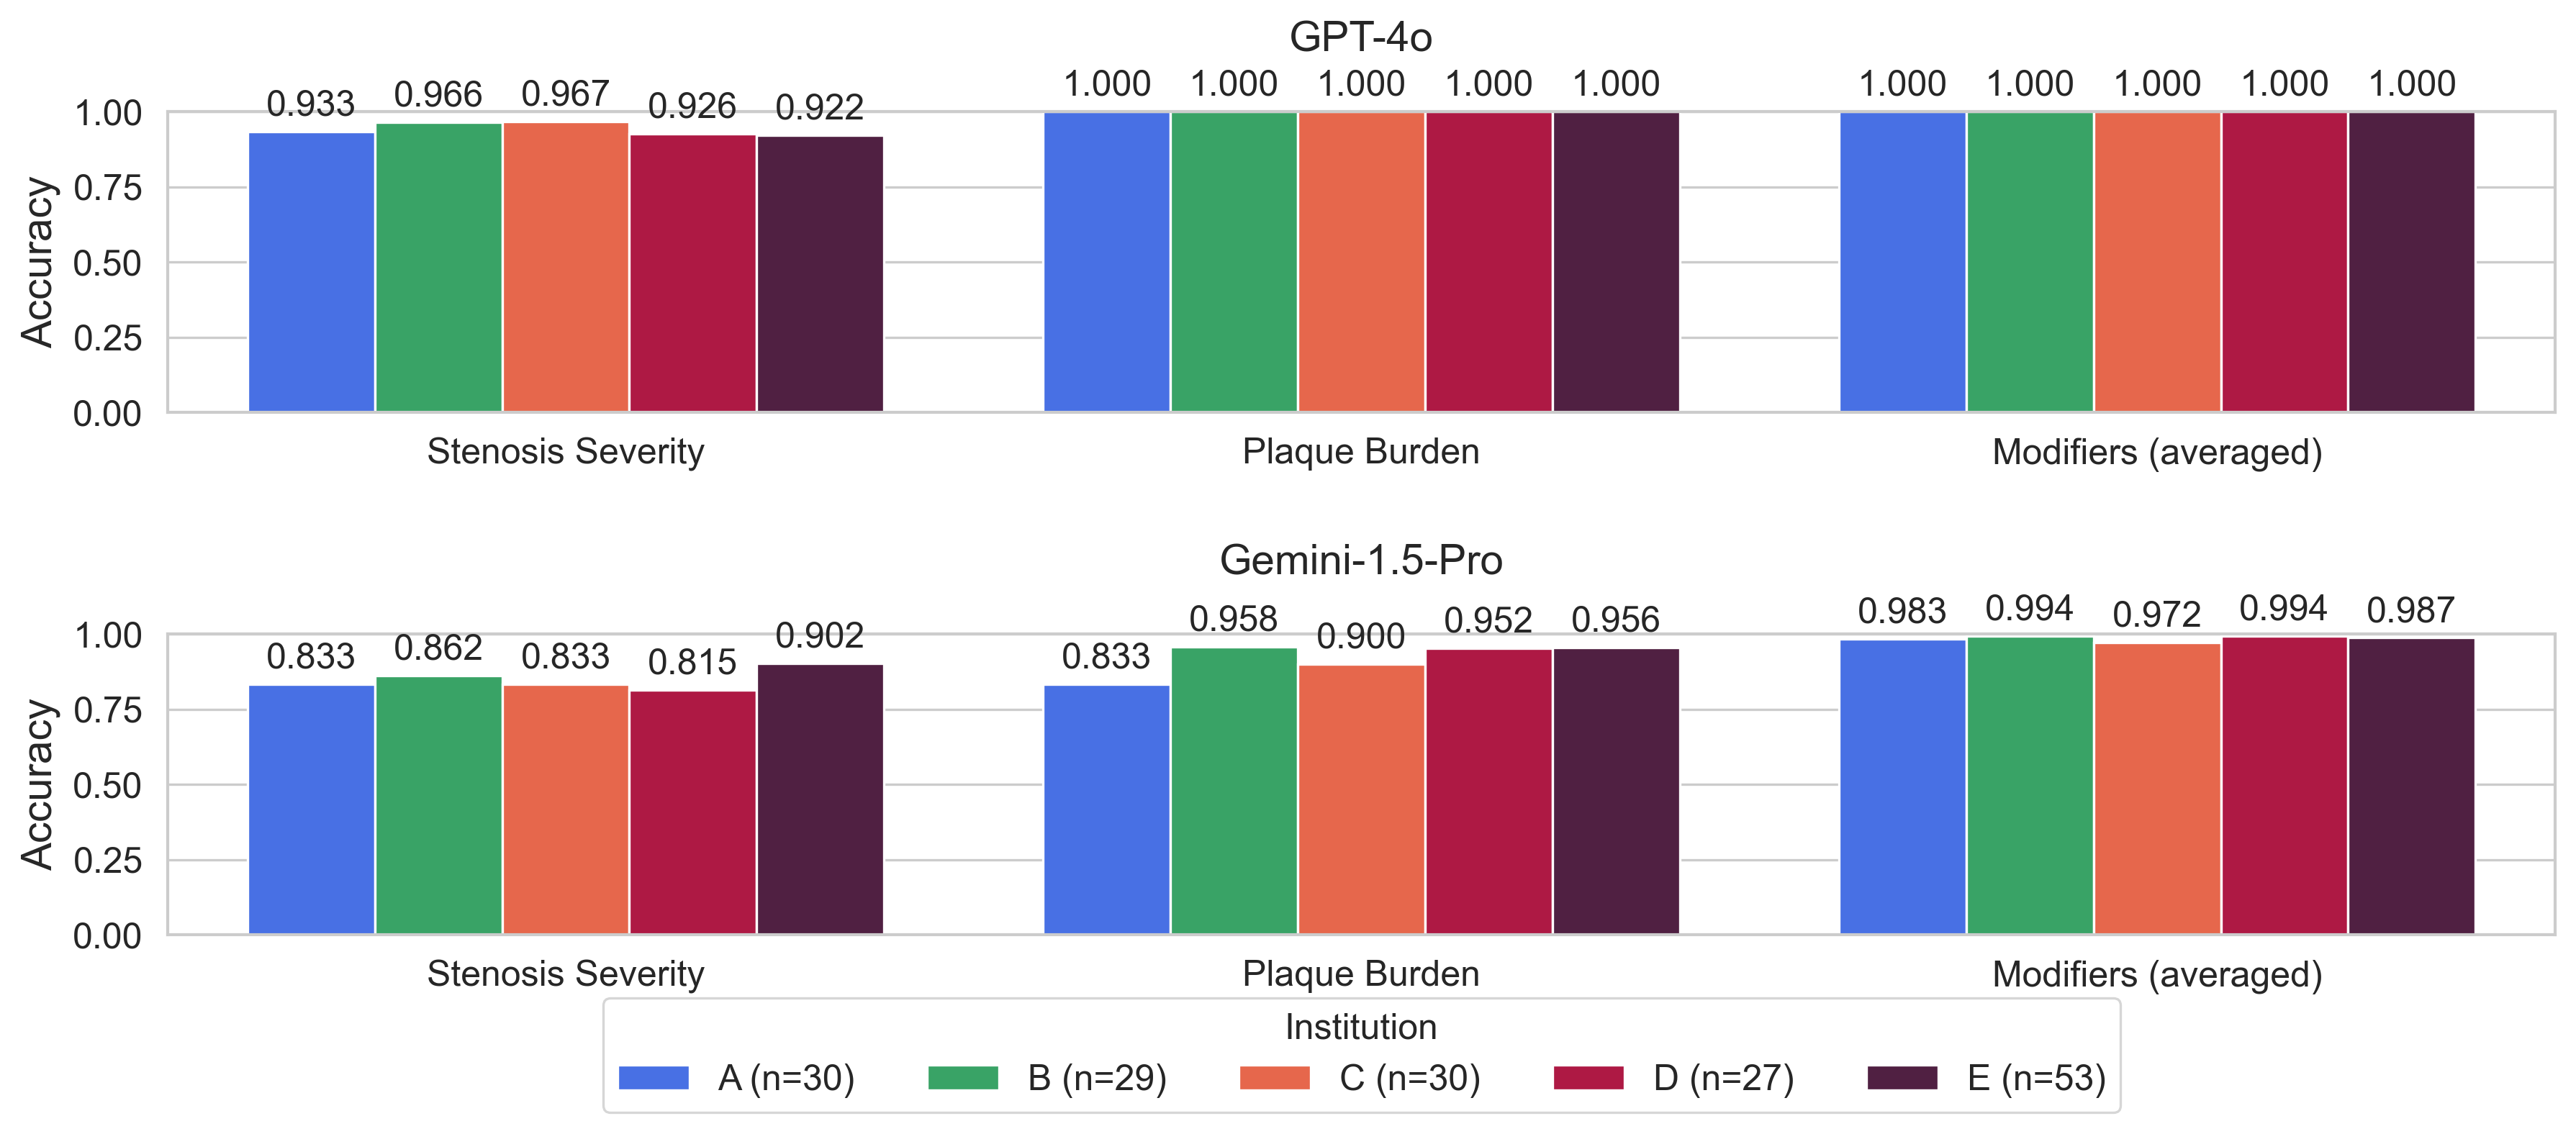

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def plot_combined_accuracy_scores_subplot(metrics_list, models):
    """
    여러 모델의 Accuracy 점수를 서브플롯으로 표시
    
    Args:
        metrics_list: List of performance metrics dictionaries [metrics_gpt, metrics_gemini]
        models: List of model names ['GPT-4o', 'Gemini-1.5-Pro']
    """
    # Style settings
    sns.set_style("whitegrid")
    sns.set_context("paper")
    plt.rcParams.update({
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'legend.title_fontsize': 12,
    })

    fig, axes = plt.subplots(2, 1, figsize=(12, 6), dpi=300)  # 3행에서 2행으로 변경
    colors = ['#2E64FE', '#28B463', '#FF5733', '#C70039', '#581845', '#8E44AD']

    category_display = {
        'CAD-RADS': 'Stenosis Severity',
        'Plaque Burden': 'Plaque Burden',
        'Modifiers (averaged)': 'Modifiers (averaged)'
    }

    categories = ['CAD-RADS', 'Plaque Burden', 'Modifiers (averaged)']

    for idx, (metrics, model) in enumerate(zip(metrics_list, models)):
        institutions = list(metrics.keys())
        
        data = []
        for institution in institutions:
            for category in categories:
                acc = metrics[institution][category]['Accuracy']
                data.append({
                    'Institution': institution, 
                    'Category': category_display[category],
                    'Accuracy': acc
                })
        
        df = pd.DataFrame(data)

        ax = axes[idx]
        bars = sns.barplot(data=df, x='Category', y='Accuracy',
                          hue='Institution', palette=colors, ax=ax)

        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f', padding=3, fontsize=12)

        ax.set_ylabel('Accuracy')
        ax.set_ylim([0, 1])
        ax.set_xlabel('')
        ax.set_title(model, pad=20)

        if idx < len(metrics_list) - 1:
            ax.get_legend().remove()
        else:
            ax.legend(loc='upper center', 
                     bbox_to_anchor=(0.5, -0.15),
                     ncol=len(institutions), title='Institution')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=2)
    plt.show()

# 데이터 준비 및 그래프 표시
plot_combined_accuracy_scores_subplot(
    [metrics_gpt, metrics_gemini],
    ['GPT-4o', 'Gemini-1.5-Pro']
)

In [17]:
metrics_gemini_manyshot['Insti']

{'A (n=30)': {'CAD-RADS': {'Accuracy': 0.625925925925926},
  'Plaque Burden': {'Accuracy': 1.0},
  'Modifiers (averaged)': {'Accuracy': 0.9851851851851853}},
 'B (n=29)': {'CAD-RADS': {'Accuracy': 0.9846743295019158},
  'Plaque Burden': {'Accuracy': 0.9953703703703705},
  'Modifiers (averaged)': {'Accuracy': 0.9987228607918264}},
 'C (n=30)': {'CAD-RADS': {'Accuracy': 0.8962962962962963},
  'Plaque Burden': {'Accuracy': 0.9888888888888889},
  'Modifiers (averaged)': {'Accuracy': 1.0}},
 'D (n=27)': {'CAD-RADS': {'Accuracy': 0.9506172839506173},
  'Plaque Burden': {'Accuracy': 1.0},
  'Modifiers (averaged)': {'Accuracy': 0.9938271604938271}},
 'E (n=53)': {'CAD-RADS': {'Accuracy': 0.9586056644880174},
  'Plaque Burden': {'Accuracy': 1.0},
  'Modifiers (averaged)': {'Accuracy': 0.9961565338923829}}}

Available institutions: ['A (n=30)' 'B (n=29)' 'C (n=30)' 'D (n=27)' 'E (n=53)']
데이터 형태 확인:
True values shape: (30,)
True values unique: ['0' '2' '3' '4A' '4B' '5']
Pred values unique: ['0' '2' '3' '4A' '5']

첫 몇 개의 예측 비교:
  True Predicted
0    2         2
1    2         2
2   4B         5
3    2         2
4   4A        4A
5    2         2
6    3         3
7    3         3
8    3         3
9    2         2

Institution: A (n=30)
Total valid cases: 30
Accuracy: 0.900
F1 Score (macro): 0.777

실제 클래스 분포:
2     14
3      7
5      5
0      2
4B     1
4A     1
Name: CAD-RADS, dtype: int64

예측 클래스 분포:
2     14
3      8
5      5
0      2
4A     1
Name: CAD-RADS, dtype: int64

Confusion Matrix:
[[ 2  0  0  0  0  0]
 [ 0 13  1  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  0  0  1]
 [ 0  1  0  0  0  4]]


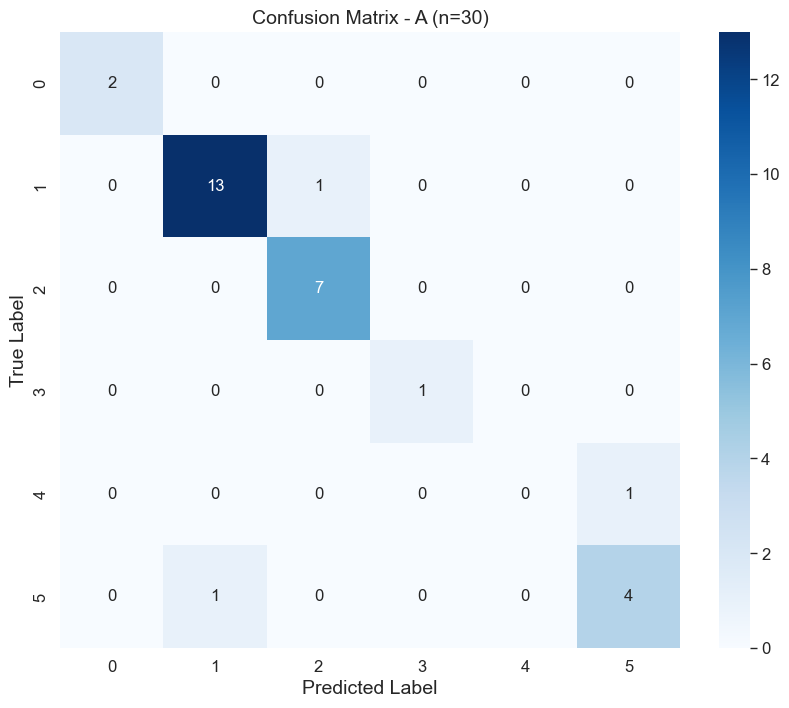

In [16]:
def verify_metrics(label, pred, institution_name):
    # 기관별 마스크 생성
    inst_mask = pred['Institution'] == institution_name
    
    # CAD-RADS에 대한 valid mask 적용
    valid_mask = (inst_mask) & (label['N'] == 0)
    
    # 실제값과 예측값 가져오기
    true_values = label.loc[valid_mask, 'CAD-RADS']
    pred_values = pred.loc[valid_mask, 'CAD-RADS']
    
    # 데이터 확인을 위한 출력
    print("데이터 형태 확인:")
    print(f"True values shape: {true_values.shape}")
    print("True values unique:", np.unique(true_values))
    print("Pred values unique:", np.unique(pred_values))
    print("\n첫 몇 개의 예측 비교:")
    comparison_df = pd.DataFrame({
        'True': true_values,
        'Predicted': pred_values
    }).head(10)
    print(comparison_df)
    
    # 각 메트릭 계산
    acc = accuracy_score(true_values, pred_values)
    f1 = f1_score(true_values, pred_values, average='macro')
    
    print(f"\nInstitution: {institution_name}")
    print(f"Total valid cases: {len(true_values)}")
    print(f"Accuracy: {acc:.3f}")
    print(f"F1 Score (macro): {f1:.3f}")
    
    # 클래스 분포 확인
    print("\n실제 클래스 분포:")
    print(true_values.value_counts())
    print("\n예측 클래스 분포:")
    print(pred_values.value_counts())
    
    # 혼동 행렬 계산 시도
    try:
        cm = confusion_matrix(true_values, pred_values)
        print("\nConfusion Matrix:")
        print(cm)
        
        # 혼동 행렬 시각화
        if cm.size > 0:  # 행렬이 비어있지 않은 경우에만 시각화
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix - {institution_name}')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()
    except Exception as e:
        print(f"\nError creating confusion matrix: {str(e)}")

# 예시: Institution 이름을 실제 데이터에서 확인
print("Available institutions:", pred_gpt['Institution'].unique())

# Institution 이름을 실제 데이터에 맞게 수정하여 실행
institution_name = pred_gpt['Institution'].unique()[0]  # 첫 번째 institution 선택
verify_metrics(label, pred_gpt, institution_name)

In [20]:
metrics_gemini_manyshot[institution]['CAD-RADS']

{'Accuracy': 0.625925925925926}

In [22]:
# 각 실험의 성능 지표를 저장할 리스트
all_performance_metrics = []

# 각 실험 파일에 대해 성능 평가 실행
for result_file in result_files:
    # 예측 결과 읽기
    pred_df = pd.read_excel(result_file)
    pred = pred_df.iloc[:,-9:-1]
    pred.columns = pred.columns.str.replace('.1', '')
    pred = pred[label.iloc[:,:-1].columns]
    pred['Institution'] = list(data['Institution'])
    
    # 각 institution과 category에 대해 accuracy와 f1 score 모두 계산
    metrics = {}
    for institution in pred['Institution'].unique():
        inst_mask = pred['Institution'] == institution
        metrics[institution] = {}
        
        # CAD-RADS에 대한 계산
        valid_mask = (inst_mask) & (label['N'] == 0)
        true_values = label.loc[valid_mask, 'CAD-RADS']
        pred_values = pred.loc[valid_mask, 'CAD-RADS']
        
        if len(true_values) > 0:
            metrics[institution]['CAD-RADS'] = {
                'Accuracy': accuracy_score(true_values, pred_values),
                'F1 Score': f1_score(true_values, pred_values, average='macro')
            }
    
    all_performance_metrics.append(metrics)

# 평균 성능 계산
metrics_gemini_manyshot = {}
for institution in all_performance_metrics[0].keys():
    metrics_gemini_manyshot[institution] = {}
    
    # CAD-RADS에 대한 평균 계산
    acc_scores = [metrics[institution]['CAD-RADS']['Accuracy'] 
                 for metrics in all_performance_metrics]
    f1_scores = [metrics[institution]['CAD-RADS']['F1 Score'] 
                for metrics in all_performance_metrics]
    
    metrics_gemini_manyshot[institution]['CAD-RADS'] = {
        'Accuracy': np.mean(acc_scores),
        'F1 Score': np.mean(f1_scores)
    }

# 결과 출력
for institution in metrics_gemini_manyshot.keys():
    if institution == "A (n=30)":
        print(f"\nInstitution: {institution}")
        print(f"Average Accuracy: {metrics_gemini_manyshot[institution]['CAD-RADS']['Accuracy']:.3f}")
        print(f"Average F1 Score: {metrics_gemini_manyshot[institution]['CAD-RADS']['F1 Score']:.3f}")

        # 단일 실험 결과와 비교
        print("\n=== Single experiment comparison ===")
        compare_models_metrics(label, pred_gemini, pred, institution, 
                             model1_name="Gemini-1.5-Pro", 
                             model2_name="Gemini-1.5-Pro Many-shot (Single Run)")

C:\Users\User\AppData\Local\Temp\ipykernel_216452\4243658500.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  pred.columns = pred.columns.str.replace('.1', '')
C:\Users\User\AppData\Local\Temp\ipykernel_216452\4243658500.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  pred.columns = pred.columns.str.replace('.1', '')
C:\Users\User\AppData\Local\Temp\ipykernel_216452\4243658500.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  pred.columns = pred.columns.str.replace('.1', '')
C:\Users\User\AppData\Local\Temp\ipykernel_216452\4243658500.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  pred.columns = pred.columns.str.replace('.1', '')
C:\Users\User\AppData\Local\Temp\ipykernel_216452\4243658500.py:9: FutureWarning: The default value of regex will change from True to False in a fut


Institution: A (n=30)
Average Accuracy: 0.626
Average F1 Score: 0.648

=== Single experiment comparison ===

=== Comparing Gemini-1.5-Pro vs Gemini-1.5-Pro Many-shot (Single Run) for A (n=30) ===

Gemini-1.5-Pro:
Total valid cases: 30
Accuracy: 0.800
F1 Score (macro): 0.629

실제 vs 예측 클래스 분포:

예측 결과 상세:
Class 0: 2/2 correct
Class 2: 12/14 correct
Class 3: 4/7 correct
Class 4A: 1/1 correct
Class 4B: 0/1 correct
Class 5: 5/5 correct

혼동 행렬:
[[ 2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  1 12  1  0  0  0]
 [ 0  0  3  4  0  0  0]
 [ 0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  5]]

Gemini-1.5-Pro Many-shot (Single Run):
Total valid cases: 30
Accuracy: 0.667
F1 Score (macro): 0.703

실제 vs 예측 클래스 분포:

예측 결과 상세:
Class 0: 2/2 correct
Class 2: 8/14 correct
Class 3: 4/7 correct
Class 4A: 1/1 correct
Class 4B: 1/1 correct
Class 5: 4/5 correct

혼동 행렬:
[[2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 5 8 0 0 0 0]
 [0 0 3 4 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [1 0 0 0 0 0 4]]


C:\Users\User\AppData\Local\Temp\ipykernel_216452\4243658500.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  pred.columns = pred.columns.str.replace('.1', '')


In [17]:
external_all = pd.read_excel('result_1014_external_all_v6.0_CoT_edit_certainty_UpperEnd.xlsx')[:169]

In [18]:
data['Institution']

0     A
1     A
2     A
3     A
4     A
     ..
55    B
56    B
57    B
58    B
59    B
Name: Institution, Length: 169, dtype: object

In [32]:
external_all['Institution']= list(data['Institution'])

In [34]:
external_all.to_excel('result_1014_external_all_v6.0_CoT_edit_certainty_UpperEnd_Institution.xlsx')